In [1]:
# Check GPU availability
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# !pip install scikeras --quiet
# !pip install keras-tuner --quiet

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
# from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from xgboost import XGBClassifier

tf.random.set_seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Load and optimize data
def reduce_memory_usage(df):
    """Downcasts numeric columns to reduce memory usage."""
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

# Split training data into features and target
X = train.drop(['id', 'rainfall'], axis=1)
y = train['rainfall']

# Save test ids and features
test_ids = test['id']
X_test = test.drop(['id'], axis=1)

## Extended Feature Engineering Functions
We define functions to generate advanced features.  
- **advanced_features** creates date‑based, periodic, and interaction/ratio features, and computes lag features for training data.  
- **additional_poly_features** generates degree‑2 polynomial features for selected key columns (after imputing missing values).  
- **rolling_features** computes rolling (7‑day and 14‑day) statistics for all numeric columns.


In [4]:
def advanced_features(df, is_train=False, target_series=None):
    """
    Create advanced features:
      - Build a date from 'day' (assume day=1 corresponds to 2024-01-01)
      - Extract date-based features (month, day_of_year, week_of_year, quarter, day_of_week, is_weekend)
      - Create periodic features (sine & cosine transforms)
      - Compute interaction/ratio features (e.g., temp_range, humidity_cloud_ratio)
      - For training data, compute lag features (gap_before_rain, gap_after_rain)
    """
    df = df.copy()
    base_date = pd.to_datetime('2024-01-01')
    df['date'] = base_date + pd.to_timedelta(df['day'] - 1, unit='D')
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['day_of_week'] = df['date'].dt.weekday
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    if 'maxtemp' in df.columns and 'mintemp' in df.columns:
        df['temp_range'] = df['maxtemp'] - df['mintemp']
    if 'temparature' in df.columns and 'dewpoint' in df.columns:
        df['temp_dew_diff'] = df['temparature'] - df['dewpoint']
    if 'humidity' in df.columns and 'cloud' in df.columns:
        df['humidity_cloud_ratio'] = df['humidity'] / (df['cloud'] + 1e-3)
    if 'sunshine' in df.columns and 'cloud' in df.columns:
        df['sunshine_cloud_ratio'] = df['sunshine'] / (df['cloud'] + 1e-3)
    if 'pressure' in df.columns and 'winddirection' in df.columns:
        df['pressure_wind_interaction'] = df['pressure'] * df['winddirection']
    if 'temparature' in df.columns and 'pressure' in df.columns:
        df['temp_pressure_ratio'] = df['temparature'] / (df['pressure'] + 1e-3)
    if 'windspeed' in df.columns and 'pressure' in df.columns:
        df['wind_pressure_ratio'] = df['windspeed'] / (df['pressure'] + 1e-3)
    if is_train:
        if target_series is not None:
            df['rainfall'] = target_series.values
        df = df.sort_values('date').reset_index(drop=True)
        df['rain_prev_day'] = df['rainfall'].shift(1).fillna(0)
        df['rain_next_day'] = df['rainfall'].shift(-1).fillna(0)
        df['gap_before_rain'] = df.groupby((df['rain_prev_day'] != df['rainfall']).cumsum()).cumcount()
        df['gap_after_rain'] = df[::-1].groupby((df['rain_next_day'] != df['rainfall']).cumsum()).cumcount()
        df.drop(['rain_prev_day', 'rain_next_day'], axis=1, inplace=True)
    else:
        df['gap_before_rain'] = 0
        df['gap_after_rain'] = 0
    df.drop(['date'], axis=1, inplace=True, errors='ignore')
    return df

def additional_poly_features(df, cols_to_expand):
    """
    Generate polynomial features (degree 2) for selected columns.
    Missing values are imputed (median) before transformation.
    """
    df_imputed = df[cols_to_expand].fillna(df[cols_to_expand].median())
    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    poly_features = poly.fit_transform(df_imputed)
    poly_feature_names = poly.get_feature_names_out(cols_to_expand)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    return poly_df

def rolling_features(df, window_sizes=[7, 14]):
    """
    Generate rolling window statistics (mean and std) for all numeric columns.
    Returns a DataFrame with new rolling features as 1D arrays.
    """
    df_roll = pd.DataFrame(index=df.index)
    for col in df.select_dtypes(include=[np.number]).columns:
        series_col = df[col]
        for window in window_sizes:
            roll_mean = series_col.rolling(window=window, min_periods=1).mean().values
            roll_std = series_col.rolling(window=window, min_periods=1).std().fillna(0).values
            if roll_mean.ndim > 1:
                roll_mean = roll_mean[:, 0]
            if roll_std.ndim > 1:
                roll_std = roll_std[:, 0]
            df_roll[f'{col}_roll_mean_{window}'] = roll_mean
            df_roll[f'{col}_roll_std_{window}'] = roll_std
    return df_roll

In [5]:
def extended_features_train(df, target_series):
    # Compute advanced features (lag features require target)
    df_adv = advanced_features(df, is_train=True, target_series=target_series)
    # Extract target
    y_out = df_adv['rainfall']
    # Drop target from features
    df_adv = df_adv.drop(['rainfall'], axis=1)
    
    # Generate polynomial features on selected candidate columns
    candidate_cols = ['maxtemp', 'mintemp', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'pressure', 'winddirection', 'windspeed']
    cols_for_poly = [col for col in candidate_cols if col in df_adv.columns]
    if cols_for_poly:
        poly_df = additional_poly_features(df_adv, cols_for_poly)
        df_adv = pd.concat([df_adv, poly_df], axis=1)
    
    # Generate rolling window features
    roll_df = rolling_features(df_adv, window_sizes=[7, 14])
    df_adv = pd.concat([df_adv, roll_df], axis=1)
    
    return df_adv, y_out

def extended_features_test(df):
    # For test data, no lag features (target not available)
    df_ext = advanced_features(df, is_train=False)
    
    candidate_cols = ['maxtemp', 'mintemp', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'pressure', 'winddirection', 'windspeed']
    cols_for_poly = [col for col in candidate_cols if col in df_ext.columns]
    if cols_for_poly:
        poly_df = additional_poly_features(df_ext, cols_for_poly)
        df_ext = pd.concat([df_ext, poly_df], axis=1)
    
    roll_df = rolling_features(df_ext, window_sizes=[7, 14])
    df_ext = pd.concat([df_ext, roll_df], axis=1)
    
    return df_ext

# Apply extended feature engineering
train_ext, y_ext = extended_features_train(pd.concat([X, y], axis=1), target_series=y)
X_ext_full = train_ext.copy()
X_test_ext_full = extended_features_test(X_test)

# Align columns between training and test sets (fill missing columns with 0)
all_cols = X_ext_full.columns.union(X_test_ext_full.columns)
X_ext_full = X_ext_full.reindex(columns=all_cols, fill_value=0)
X_test_ext_full = X_test_ext_full.reindex(columns=all_cols, fill_value=0)

print("Extended Train Shape:", X_ext_full.shape)
print("Extended Test Shape:", X_test_ext_full.shape)

Extended Train Shape: (2190, 435)
Extended Test Shape: (730, 435)


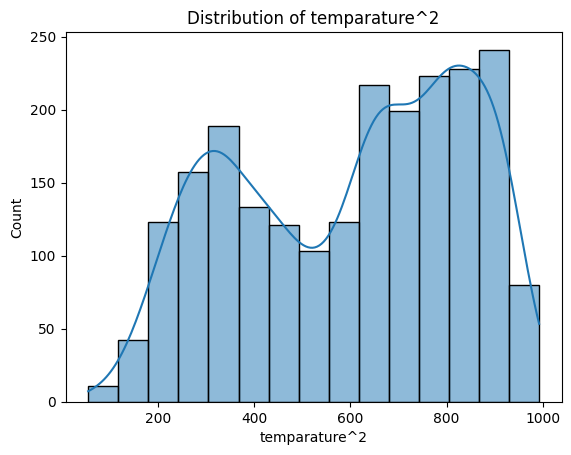

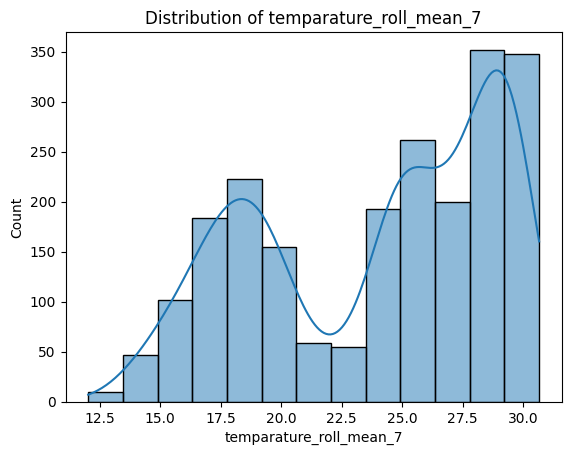

In [6]:
# Plot a sample polynomial feature (if exists)
sample_poly = [col for col in X_ext_full.columns if 'temparature' in col and '^2' in col]
if sample_poly:
    sns.histplot(X_ext_full[sample_poly[0]], kde=True)
    plt.title(f"Distribution of {sample_poly[0]}")
    plt.show()

# Plot a sample rolling feature, e.g., temparature_roll_mean_7, if it exists
if 'temparature_roll_mean_7' in X_ext_full.columns:
    sns.histplot(X_ext_full['temparature_roll_mean_7'], kde=True)
    plt.title("Distribution of temparature_roll_mean_7")
    plt.show()

## Outlier Treatment (IQR Method)

We apply IQR-based clipping to reduce the impact of extreme values in the engineered features.


In [7]:
def treat_outliers_iqr(df):
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        series = df[col].squeeze()  # Ensure it's a 1D array/Series
        Q1 = np.nanquantile(series, 0.25)
        Q3 = np.nanquantile(series, 0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        # Convert to NumPy array, clip, and assign back
        df[col] = np.clip(series.values, lower, upper)
    return df

# Now apply the function on the extended feature sets:
X_ext_iqr = treat_outliers_iqr(X_ext_full)
X_test_ext_iqr = treat_outliers_iqr(X_test_ext_full)

## Define Pipeline Function for Model Training and Submission
We build a pipeline (imputation → scaling → model), perform hyperparameter tuning with RandomizedSearchCV, and save a submission file.  
Before prediction, we reindex the test set to match the training set columns.

In [8]:
def train_and_submit(X_train, y_train, X_pred, model, param_dist, model_name):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = RandomizedSearchCV(pipeline, param_dist, n_iter=20, scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    
    best_score = search.best_score_
    print(f"Best CV ROC AUC for {model_name}: {best_score:.4f}")
    print("Best Params:", search.best_params_)
    
    # Align test set columns to match training set
    training_cols = X_train.columns
    X_pred_aligned = X_pred.reindex(columns=training_cols, fill_value=0)
    
    try:
        preds = search.predict_proba(X_pred_aligned.values)[:, 1]
    except Exception as e:
        print(f"Error in predict_proba for {model_name}: {e}")
        preds = np.full(len(X_pred_aligned), 0.5)
    
    submission = pd.DataFrame({'id': test_ids, 'rainfall': preds})
    submission.to_csv(f"{model_name}_submission.csv", index=False)
    return best_score

## Train Multiple Models (Excluding DNN)

We define parameter grids for each model and then loop over each model to perform hyperparameter tuning and save a submission file.

In [9]:
# Define parameter grids for each model:
param_grids = {
    'LogisticRegression': {
        'clf__C': np.logspace(-3, 2, 10),
        'clf__solver': ['lbfgs', 'liblinear']
    },
    'DecisionTree': {
        'clf__max_depth': [3, 5, 7, None],
        'clf__min_samples_split': [2, 5, 10]
    },
    'ExtraTrees': {
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [5, 7, None]
    },
    'RandomForest': {
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [5, 7, None]
    },
    'XGBoost': {
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [3, 5, 7]
    },
    'CatBoost': {
        'clf__iterations': [100, 200],
        'clf__depth': [4, 6]
    },
    'LGBM': {
        'clf__num_leaves': [31, 50],
        'clf__n_estimators': [50, 100, 150]
    },
    'KNN': {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    },
    'SVC': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    }
}

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LGBM': LGBMClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42)
}

model_results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name} on Extended IQR-treated & Standard Scaled features:")
    auc = train_and_submit(X_ext_iqr, y_ext, X_test_ext_iqr, model, param_grids[model_name], model_name)
    model_results[model_name] = auc


Training LogisticRegression on Extended IQR-treated & Standard Scaled features:
Best CV ROC AUC for LogisticRegression: 0.9369
Best Params: {'clf__solver': 'lbfgs', 'clf__C': 0.1668100537200059}

Training DecisionTree on Extended IQR-treated & Standard Scaled features:
Best CV ROC AUC for DecisionTree: 0.8904
Best Params: {'clf__min_samples_split': 2, 'clf__max_depth': 3}

Training ExtraTrees on Extended IQR-treated & Standard Scaled features:
Best CV ROC AUC for ExtraTrees: 0.9118
Best Params: {'clf__n_estimators': 100, 'clf__max_depth': 7}

Training RandomForest on Extended IQR-treated & Standard Scaled features:
Best CV ROC AUC for RandomForest: 0.9202
Best Params: {'clf__n_estimators': 100, 'clf__max_depth': 7}

Training XGBoost on Extended IQR-treated & Standard Scaled features:
Best CV ROC AUC for XGBoost: 0.9478
Best Params: {'clf__n_estimators': 50, 'clf__max_depth': 3}

Training CatBoost on Extended IQR-treated & Standard Scaled features:
Best CV ROC AUC for CatBoost: 0.9479


## Graphical Comparison of Model Performances

We create a bar plot comparing the ROC AUC scores of all models trained on the extended features.

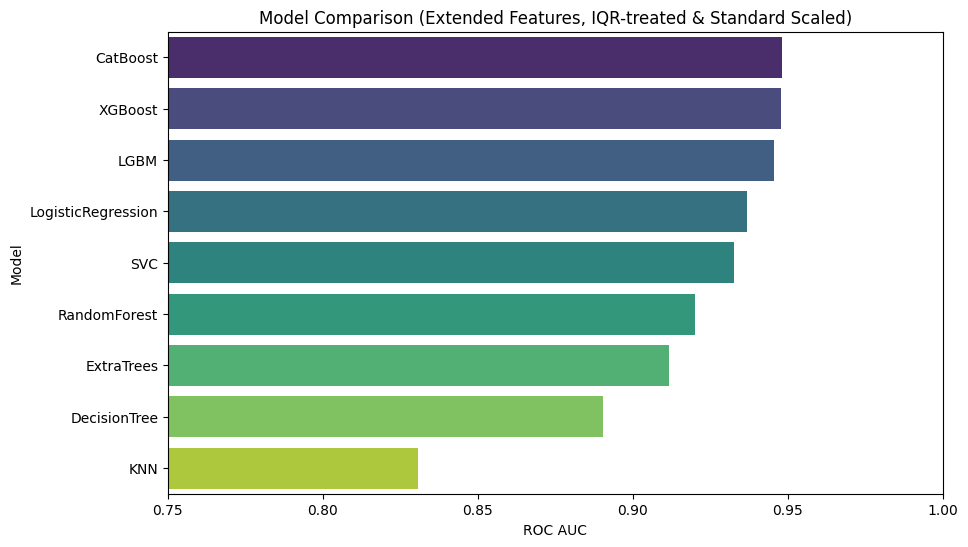

In [10]:
results_df = pd.DataFrame(model_results.items(), columns=['Model', 'AUC']).sort_values(by='AUC', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison (Extended Features, IQR-treated & Standard Scaled)')
plt.xlabel('ROC AUC')
plt.xlim(0.75, 1.0)
plt.show()

In [11]:
import shutil

# Map model names to their saved submission filenames
submission_files = {
    'LogisticRegression': "LogisticRegression_submission.csv",
    'DecisionTree': "DecisionTree_submission.csv",
    'ExtraTrees': "ExtraTrees_submission.csv",
    'RandomForest': "RandomForest_submission.csv",
    'XGBoost': "XGBoost_submission.csv",
    'CatBoost': "CatBoost_submission.csv",
    'LGBM': "LGBM_submission.csv",
    'KNN': "KNN_submission.csv",
    'SVC': "SVC_submission.csv"
}

# Identify best model based on AUC scores
best_model = max(model_results, key=model_results.get)
best_submission_file = submission_files.get(best_model)

# Save best model's submission as 'submission.csv'
if best_submission_file is None:
    raise ValueError("Best model submission file not found.")
else:
    shutil.copy(best_submission_file, "submission.csv")
    print(f"Best scoring model: {best_model}")
    print(f"Copied {best_submission_file} as 'submission.csv'")

# Confirm all individual model submission files exist
print("\n All individual model submissions saved:")
for model, filename in submission_files.items():
    print(f"- {filename}")

Best scoring model: CatBoost
Copied CatBoost_submission.csv as 'submission.csv'

 All individual model submissions saved:
- LogisticRegression_submission.csv
- DecisionTree_submission.csv
- ExtraTrees_submission.csv
- RandomForest_submission.csv
- XGBoost_submission.csv
- CatBoost_submission.csv
- LGBM_submission.csv
- KNN_submission.csv
- SVC_submission.csv


## Conclusion

### Conclusion
- **Extended Feature Engineering:**  
  We created an extensive feature set (over 100 new features) by combining:
    - Advanced date‑based features and periodic transformations,
    - Interaction/ratio features,
    - Polynomial features (degree 2) on key numeric columns,
    - Rolling window statistics (7‑day and 14‑day).
  For training, we computed lag features and then dropped the target (and any target‑derived rolling features) so that train and test have identical columns.

- **Outlier Treatment:**  
  IQR‑based clipping was applied to the extended feature set.

- **Modeling:**  
  Multiple models (Logistic Regression, Decision Tree, ExtraTrees, RandomForest, XGBoost, CatBoost, LGBM, KNN, and SVC) were trained using RandomizedSearchCV with 5‑fold cross‑validation.

- **Performance Comparison:**  
  A bar plot visualizes the ROC AUC scores.

- **Final Submission:**  
  The best scoring model’s submission file is automatically copied to `submission.csv`.

This comprehensive approach leverages extensive, meaningful feature engineering and rigorous hyperparameter tuning to maximize performance. Adjust candidate columns and parameter grids as needed. Happy modeling and best of luck in the competition!
